# Visualization and Analysis for hybrid perovskite single crystal data
    ## Author: Zhi Li
    ## Version 1.1
    ## 10-28-2019

In [172]:
import os, fnmatch
import matplotlib as mpl
import math
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.font_manager import FontProperties
from scipy.spatial import ConvexHull
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.mplot3d.art3d import Poly3DCollection, Line3DCollection
from matplotlib.colors import Normalize
from sklearn.preprocessing import StandardScaler
from scipy.spatial.distance import pdist, cdist, squareform
from sklearn.neighbors import KNeighborsClassifier
from sklearn import tree
from sklearn.externals.six import StringIO
from IPython.display import Image  
from sklearn.tree import export_graphviz
import pydotplus
import optunity
import optunity.metrics

## What amines we have tried?

In [173]:
file = "0042.perovskitedata_RAPID.csv" # data file, 26 amines
df=pd.read_csv(file)
Inchi = pd.read_csv("Organic Inchikey.csv")
Inchidict = dict(zip(Inchi['Chemical Name'], Inchi['InChI Key (ID)']))

Amine_done = []
for i in df['_rxn_organic_inchikey']:
    if i not in Amine_done: 
        Amine_done.append(i)
Amine_number = len(Amine_done)
for i in range(Amine_number):
    Amine_done[i] = dict(zip(Inchi['InChI Key (ID)'],Inchi['Chemical Name']))[Amine_done[i]]
print (Amine_done)
print ('*'*120)
print ('Number of amines:', Amine_number)

['N,N-Dimethylethane- 1,2-diammonium iodide', 'Pyridinium Iodide', 'n-Butylammonium iodide', 'neo-Pentylammonium iodide', 'Pyrrolidinium Iodide', 'iso-Butylammonium iodide', '4-Fluoro-Phenylammonium iodide', 'Acetamidinium iodide', 'N-propylammonium Iodide', 'Piperidinium Iodide', 'n-Octylammonium Iodide', 'Ethane-1,2-diammonium iodide', 'Imidazolium Iodide', 'N,N-dimethylpropane- 1,3-diammonium iodide', 'Dimethylammonium iodide', 'Phenylammonium Iodide', '4-Trifluoromethyl-Phenylammonium iodide', '4-Fluoro-Benzylammonium iodide', 'Methylammonium iodide', 't-Butylammonium Iodide', '4-Fluoro-Phenethylammonium iodide', 'N,N-Diethylpropane-1,3-diammonium iodide', 'Di-isopropylammonium iodide', 'Benzylammonium Iodide', 'n-Dodecylammonium iodide', 'Formamidinium Iodide', '4-methoxy-phenethylammonium-iodide', '4-Methoxy-Phenylammonium iodide', 'Piperazine-1,4-diium iodide', '1,4-Benzene diammonium iodide', '4-Trifluoromethyl-Benzylammonium iodide', 'Propane-1,3-diammonium iodide', 'Phenethyl

## Function for basic data analysis

In [174]:
# function for specific amine, crystal class
def per3D(points, amine = None, category = None, \
          dim = ['_rxn_M_inorganic', '_rxn_M_organic', '_rxn_M_acid']):
    if amine is not None: amine = Inchidict[amine]
    if amine is None:
        if category is None:
            All_points = np.zeros((points.shape[0], 4))
            for i in range(3):
                All_points[:,i] = points[dim[i]]
            All_points[:,3] = points['_out_crystalscore']
        else:
            All_points = np.zeros((points[points['_out_crystalscore'] == category].shape[0], 4))
            for i in range(3):
                All_points[:,i] = points[dim[i]][points['_out_crystalscore'] == category]
            All_points[:,3] = points['_out_crystalscore'][points['_out_crystalscore'] == category]    
    else:
        if category is None:
            All_points = np.zeros((points[points["_rxn_organic_inchikey"] == amine].shape[0], 4))
            for i in range(3):
                All_points[:,i] = points[dim[i]][points["_rxn_organic_inchikey"] == amine]
            All_points[:,3] = points['_out_crystalscore'][points["_rxn_organic_inchikey"] == amine]
        else:
            All_points = np.zeros((points[points["_rxn_organic_inchikey"] == amine][points['_out_crystalscore'] == category].shape[0], 4))
            for i in range(3):
                All_points[:,i] = points[dim[i]][points["_rxn_organic_inchikey"] == amine][points['_out_crystalscore'] == category]
            All_points[:,3] = points['_out_crystalscore'][points["_rxn_organic_inchikey"] == amine][points['_out_crystalscore'] == category]
    
    return All_points



def plot3d2d (point, x_range = [0, 2], y_range = [0, 5], z_range = [0, 10.5], xy_loc = -3, xz_loc = 0.1, yz_loc = -0.5,\
              x_step = 0.5, y_step = 1, z_step = 2, elev = 45, azim = -70):
    %matplotlib notebook
    xy_plane = z_range[0] + xy_loc
    xz_plane = y_range[1] + xz_loc
    yz_plane = x_range[0] + yz_loc
    # 3D plot
    color_type = ['blue', 'green','orange','red']
    color_type_2D = ['navy', 'darkgreen','orange','darkred']
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    for i in range(1,5):
        s = 5 if i == 4 else 5
        ax.scatter(point[:,0][point[:,3]==i], point[:,1][point[:,3]==i], point[:,2][point[:,3]==i],\
                   c = color_type[i-1], s = s, alpha=0.5)   
    # 2D projections plot
    for i in range(1,5):
        s = 3 if i == 4 else 3
        arf = 0.2 if i == 4 else 0.1
        ax.scatter(point[:,0][point[:,3]==i],point[:,2][point[:,3]==i], \
                   marker = 'o', c = color_type_2D[i-1], s = s, zdir = 'y', zs = xz_plane, alpha=arf)
        ax.scatter(point[:,1][point[:,3]==i], point[:,2][point[:,3]==i], \
                   marker = 'o', c = color_type_2D[i-1], s = s, zdir = 'x', zs = yz_plane, alpha=arf)
        ax.scatter(point[:,0][point[:,3]==i], point[:,1][point[:,3]==i], \
                   marker = 'o', c = color_type_2D[i-1], s = s, zdir='z', zs = xy_plane, alpha=arf)
    # make 2D planes with meshgrid
    # yz plane
    yy, zz = np.meshgrid(np.arange(y_range[0],y_range[1]+y_step, y_step), np.arange(z_range[0],z_range[1]+z_step,z_step))
    xx = np.ones((len(np.arange(z_range[0],z_range[1]+z_step,z_step)), len(np.arange(y_range[0],y_range[1]+y_step, y_step))))*yz_plane
    ax.plot_surface(xx,yy,zz, color = "silver", alpha = 0.1)
    ax.plot_wireframe(xx,yy,zz, color = "black", alpha = 0.1)
    # xy plane
    xx, yy = np.meshgrid(np.arange(x_range[0],x_range[1]+x_step, x_step), np.arange(y_range[0],y_range[1]+y_step, y_step))
    zz = np.ones((len(np.arange(y_range[0],y_range[1]+y_step, y_step)), len(np.arange(x_range[0],x_range[1]+x_step, x_step))))*xy_plane
    ax.plot_surface(xx,yy,zz, color = "silver", alpha = 0.1)
    ax.plot_wireframe(xx,yy,zz, color = "black", alpha = 0.1)
    # xz plane
    xx, zz = np.meshgrid(np.arange(x_range[0],x_range[1]+x_step, x_step), np.arange(z_range[0],z_range[1]+z_step,z_step))
    yy = np.ones((len(np.arange(z_range[0],z_range[1]+z_step, z_step)), len(np.arange(x_range[0],x_range[1]+x_step, x_step))))*xz_plane
    ax.plot_surface(xx,yy,zz, color = "silver", alpha = 0.1)
    ax.plot_wireframe(xx,yy,zz, color = "black", alpha = 0.1)
    # set axis, limit.
    ax.set_axis_off()
    ax.view_init(elev=elev, azim=azim)
    ax.set_xlim(yz_plane, x_range[1])
    ax.set_ylim(y_range[0],xz_plane)
    ax.set_zlim(xy_plane,z_range[1])
    plt.savefig('Graphs/Outcome_plot_'+ amine_name + '.svg', format = "svg", transparent=True)


    
# Check if point is in convexhull
def point_in_hull(point, hull, tolerance = 1e-12):
    return all((np.dot(equ[:-1],point) + equ[-1] <= tolerance) for equ in hull.equations)


# Generate meshgrid points of certain size and location
def gridgen(n=20,x=3,y=4,z=10, plot = False):
    a = np.linspace(0,x,n)
    b = np.linspace(0,y,n)
    c = np.linspace(0,z,n)
    points = np.zeros((n*n*n,3))
    xv,yv,zv = np.meshgrid(a,b,c)
    if plot: 
        fig = plt.figure()
        ax = fig.add_subplot(111, projection='3d')
        ax.scatter(xv, yv, zv, c = 'coral', s = 5)
    for i in range(n*n*n):
        points[i] = [xv.flatten()[i], yv.flatten()[i], zv.flatten()[i]]
    return points


## Data visualization

In [175]:
print (Amine_done)

['N,N-Dimethylethane- 1,2-diammonium iodide', 'Pyridinium Iodide', 'n-Butylammonium iodide', 'neo-Pentylammonium iodide', 'Pyrrolidinium Iodide', 'iso-Butylammonium iodide', '4-Fluoro-Phenylammonium iodide', 'Acetamidinium iodide', 'N-propylammonium Iodide', 'Piperidinium Iodide', 'n-Octylammonium Iodide', 'Ethane-1,2-diammonium iodide', 'Imidazolium Iodide', 'N,N-dimethylpropane- 1,3-diammonium iodide', 'Dimethylammonium iodide', 'Phenylammonium Iodide', '4-Trifluoromethyl-Phenylammonium iodide', '4-Fluoro-Benzylammonium iodide', 'Methylammonium iodide', 't-Butylammonium Iodide', '4-Fluoro-Phenethylammonium iodide', 'N,N-Diethylpropane-1,3-diammonium iodide', 'Di-isopropylammonium iodide', 'Benzylammonium Iodide', 'n-Dodecylammonium iodide', 'Formamidinium Iodide', '4-methoxy-phenethylammonium-iodide', '4-Methoxy-Phenylammonium iodide', 'Piperazine-1,4-diium iodide', '1,4-Benzene diammonium iodide', '4-Trifluoromethyl-Benzylammonium iodide', 'Propane-1,3-diammonium iodide', 'Phenethyl

<IPython.core.display.Javascript object>


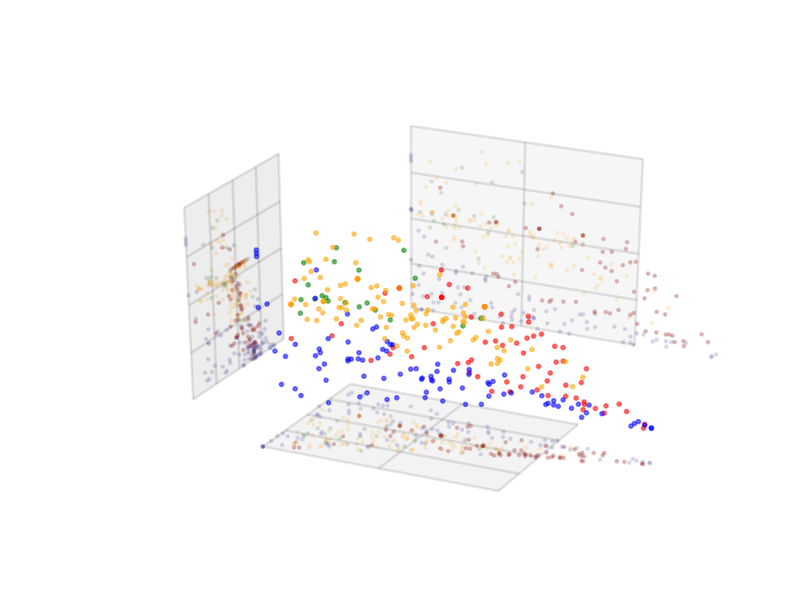

{1.0: 93, 2.0: 20, 3.0: 107, 4.0: 71}

In [398]:
amine_name = "Dimethylammonium iodide" # The ammonium you would like to plot

# 3D plot
point = per3D(df,amine = amine_name,category = None)
plot3d2d(point=point, x_range = [0, 1], y_range = [0, 2], z_range = [0, 16], xy_loc = -3, xz_loc = 1.5, yz_loc = -0.3,\
         x_step = 0.5, y_step = 0.5, z_step = 4, elev = 27, azim = -64)
point[:,3]
unique, counts = np.unique(point[:,3], return_counts=True)
dict(zip(unique, counts))

In [399]:
np.shape(point[:,3])

(291,)

## Convexhull calcuation for different classes

In [364]:
# Calculate convexhull for class4 and total
point_1 = per3D(df,amine = amine_name, category = 1)
point_2 = per3D(df,amine = amine_name, category = 2)
point_3 = per3D(df,amine = amine_name, category = 3)
point_4 = per3D(df,amine = amine_name, category = 4)
point_all = per3D(df,amine = amine_name)

if np.shape(point_1[:,0:3])[0]>3:
    hull_1 = ConvexHull(point_1[:,0:3])
if np.shape(point_2[:,0:3])[0]>3:
    hull_2 = ConvexHull(point_2[:,0:3])
if np.shape(point_3[:,0:3])[0]>3:
    hull_3 = ConvexHull(point_3[:,0:3])
if np.shape(point_4[:,0:3])[0]>3:
    hull_4 = ConvexHull(point_4[:,0:3])
if np.shape(point_all[:,0:3])[0]>3:
    hull_all = ConvexHull(point_all[:,0:3])

vol_percentage = round((hull_4.volume/hull_all.volume)*100,1)
print("volume of class 4 is", hull_4.volume)
print("volume of class 1-4 is", hull_all.volume)
print("volume percentage for " + amine_name + " is " + str(vol_percentage) +" %")

volume of class 4 is 0.9243858059580934
volume of class 1-4 is 8.013680787033385
volume percentage for N,N-dimethylpropane- 1,3-diammonium iodide is 11.5 %


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:23: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


## Calculate Meshgrid points in the convexhulls

In [378]:
## Plotting Parameters
xlim = [0,1.5]
ylim = [0,2]
zlim = [0,16]
view = [-64,31]
grid_n = 20

In [379]:
# Generate meshgrid point
grid_points = gridgen(n=grid_n,x=xlim[1],y=ylim[1],z=zlim[1])

# Search and plot meshgrid points in class4 hull and total hull (also find meshgrid point in other hulls)
point_in_box_1 = []
point_in_box_2 = []
point_in_box_3 = []
point_in_box_4 = []
point_in_box_all = []
point_in_box_non4 = []

for j in grid_points:
    if point_in_hull(j, hull_all):
        point_in_box_all.append(list(j))
        if point_in_hull(j, hull_4):
            point_in_box_4.append(list(j))
        else: 
            point_in_box_non4.append(list(j))
            if point_in_hull(j, hull_3):
                point_in_box_3.append(list(j))
            elif point_in_hull(j, hull_2):
                point_in_box_2.append(list(j))
            elif point_in_hull(j, hull_1):
                point_in_box_1.append(list(j))

point_in_box_1 = np.array(point_in_box_1)
point_in_box_2 = np.array(point_in_box_2)
point_in_box_3 = np.array(point_in_box_3)
point_in_box_4 = np.array(point_in_box_4)
point_in_box_all = np.array(point_in_box_all)
point_in_box_non4 = np.array(point_in_box_non4)

## Plot convexhull + grid points (4 + all)

<IPython.core.display.Javascript object>


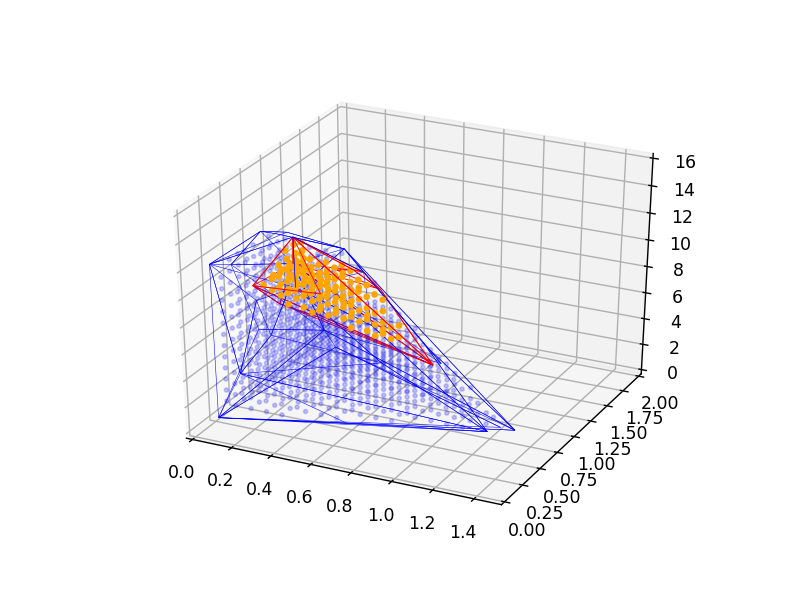

In [380]:
%matplotlib notebook
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Plot meshgrid points in envelope
ax.scatter(point_in_box_4[:,0], point_in_box_4[:,1], point_in_box_4[:,2], c = 'orange', alpha = 1, s = 8)
ax.scatter(point_in_box_non4[:,0], point_in_box_non4[:,1], point_in_box_non4[:,2], c = 'blue', alpha = 0.2, s = 5)

# Plot the "envelope"
n_facet_4 = np.shape(hull_4.simplices)[0]
n_facet_all = np.shape(hull_all.simplices)[0]
facets_4 = np.zeros((n_facet_4,3,3))
facets_all = np.zeros((n_facet_all,3,3))

for i in range(n_facet_4):
    for j in range(3):
        facets_4[i][j] = point_4[hull_4.simplices[i][j],0:3]
        
for i in range(n_facet_all):
    for j in range(3):
        facets_all[i][j] = point_all[hull_all.simplices[i][j],0:3] 

for i in range(n_facet_4):
    x = [facets_4[i][0][0],facets_4[i][1][0],facets_4[i][2][0]]
    y = [facets_4[i][0][1],facets_4[i][1][1],facets_4[i][2][1]]
    z = [facets_4[i][0][2],facets_4[i][1][2],facets_4[i][2][2]]
    verts = [list(zip(x, y, z))]
    ax.add_collection3d(Line3DCollection(verts, colors='red', linewidths=0.5))

for i in range(n_facet_all):
    x = [facets_all[i][0][0],facets_all[i][1][0],facets_all[i][2][0]]
    y = [facets_all[i][0][1],facets_all[i][1][1],facets_all[i][2][1]]
    z = [facets_all[i][0][2],facets_all[i][1][2],facets_all[i][2][2]]
    verts = [list(zip(x, y, z))]
    ax.add_collection3d(Line3DCollection(verts, colors='blue', linewidths=0.3))


ax.set_xlim(xlim[0],xlim[1])
ax.set_ylim(ylim[0],ylim[1])
ax.set_zlim(zlim[0],zlim[1])
ax.view_init(azim = view[0],elev = view[1])
plt.savefig('Graphs/Grid points+Envelope_' + amine_name + '.svg', format = 'svg', transparent = True, dpi = 1000)

## Plot the class 4 convexhull only

<IPython.core.display.Javascript object>


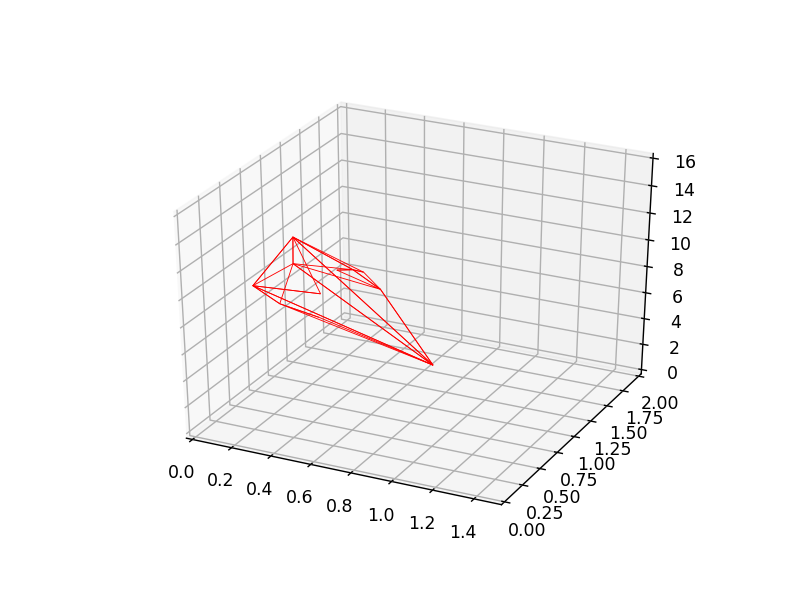

In [381]:
%matplotlib notebook
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

n_facet_4 = np.shape(hull_4.simplices)[0]
n_facet_all = np.shape(hull_all.simplices)[0]
facets_4 = np.zeros((n_facet_4,3,3))
facets_all = np.zeros((n_facet_all,3,3))

for i in range(n_facet_4):
    for j in range(3):
        facets_4[i][j] = point_4[hull_4.simplices[i][j],0:3]

for i in range(n_facet_4):
    x = [facets_4[i][0][0],facets_4[i][1][0],facets_4[i][2][0]]
    y = [facets_4[i][0][1],facets_4[i][1][1],facets_4[i][2][1]]
    z = [facets_4[i][0][2],facets_4[i][1][2],facets_4[i][2][2]]
    verts = [list(zip(x, y, z))]
    ax.add_collection3d(Line3DCollection(verts, colors='red', linewidths=0.5))

ax.set_xlim(xlim[0],xlim[1])
ax.set_ylim(ylim[0],ylim[1])
ax.set_zlim(zlim[0],zlim[1])
ax.view_init(azim = view[0],elev = view[1])
plt.savefig('Graphs/Class 4 envelop_'+ amine_name + '.svg', format = 'svg', transparent = True, dpi = 1000)

## Nearest Neighbors to find purity of Class 4 envelope

In [373]:
# Building distance matrix (# meshgrid point in class 4 convexhull X # all point)
distance = cdist(point_in_box_4, point_all[:,0:3], 'euclidean') # Calculate the distance between meshgrid point and all class in class 4 convexhull
distance_class_ = np.concatenate((distance, [point_all[:,3]]), axis = 0) # Add the last row as class of all points

In [382]:
k = 5 # number of neighbor is considering
threshold = 2 # dont't know how to use this yet

# Finding the k-nearest neighbors for meshgrid point
vote_list = []
for i in range(np.shape(point_in_box_4)[0]):
    lst = np.zeros((np.shape(point_all)[0],2))
    lst[:,0] = distance[i]
    lst[:,1] = point_all[:,3]
    lst = list(lst)
    lst.sort(key=lambda tup: tup[0])
    lst = np.array(lst[:k])
    if all(list(lst[:,1]).count(4) >= list(lst[:,1]).count(j) for j in [1,2,3]):
        vote_list.append(4) # if vote is 4
    else:
        vote_list.append(0) # if vote is other than 4, set as "0"

point_in_box_4_vote = np.zeros((np.shape(point_in_box_4)[0],4))
point_in_box_4_vote[:,0:3] = point_in_box_4 # coordiation of point in class 4 convexhull
point_in_box_4_vote[:,3] = vote_list # vote of point in class 4 convexhull

In [383]:
# "Fill Factor" (predicted class 4 over all) and "Fuzzy Edege Factor" (predicted non-class 4 over all) calculation.
class4_num = 0
class123_num = 0
for i in point_in_box_4_vote:
    if i[3] == 4:
        class4_num += 1
    else:
        class123_num += 1
FF = round(class4_num/(np.shape(point_in_box_4)[0]),2)
FEF = round(class123_num/(np.shape(point_in_box_4)[0]),2)
print("Fill factor is ", FF)
print("Fuzzy edge factor is ", FEF)

Fill factor is  0.47
Fuzzy edge factor is  0.53


<IPython.core.display.Javascript object>


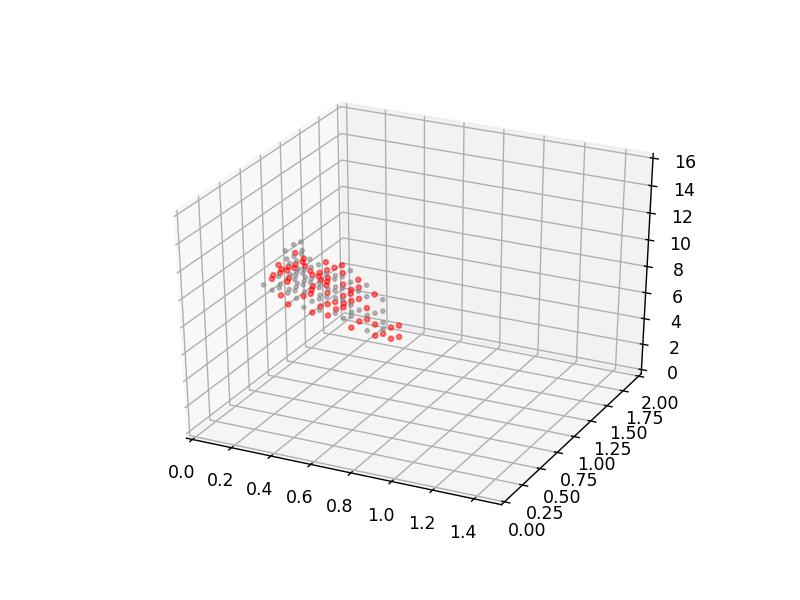

In [384]:
# Plot real class 4 and fake class 4
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
img = ax.scatter(point_in_box_4_vote[:,0][point_in_box_4_vote[:,3] == 4], \
                 point_in_box_4_vote[:,1][point_in_box_4_vote[:,3] == 4], \
                 point_in_box_4_vote[:,2][point_in_box_4_vote[:,3] == 4], \
                 c = "red", s = 8, alpha = 0.5)
img = ax.scatter(point_in_box_4_vote[:,0][point_in_box_4_vote[:,3] == 0], \
                 point_in_box_4_vote[:,1][point_in_box_4_vote[:,3] == 0], \
                 point_in_box_4_vote[:,2][point_in_box_4_vote[:,3] == 0], \
                 c = "gray", s = 5, alpha = 0.5)

ax.set_xlim(xlim[0],xlim[1])
ax.set_ylim(ylim[0],ylim[1])
ax.set_zlim(zlim[0],zlim[1])
ax.view_init(azim = view[0],elev = view[1])

# fig.colorbar(img)
plt.savefig('Graphs/Patriots and Traitors in Envelope_'+ amine_name + '.svg', format = "svg", transparent=True, dpi = 1000)